In [64]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
import pipeline
import json
from skimage import util
from skimage import io


def read_annotation_file(path):
    '''This creates a dictionary where the first key is the sequence id,
    and the second key is the frame id, which contains a list of the 
    annotation points as lists of floating numbers.
    For example sequence #1 shown above contains 3 objects, which are visible in both frames #1 and #3.'''
    with open(path) as annotation_file:
        annotation_list = json.load(annotation_file)
    # Transform list of annotations into dictionary
    annotation_dict = {}
    for annotation in annotation_list:
        sequence_id = annotation['sequence_id']
        if sequence_id not in annotation_dict:
            annotation_dict[sequence_id] = {}
        annotation_dict[sequence_id][annotation['frame']] = annotation['object_coords']
    return annotation_dict


def get_targets(dataset, seqid):
    '''Returns array of n_objects x n_frames x coords'''
    return np.array([dataset[seqid][frame] for frame in dataset[seqid]]).swapaxes(0, 1)


def draw_circle(ax, r, c, radius, color):
    circle = plt.Circle((c, r), radius, color=color, fill=False)
    ax.add_artist(circle)

    
def draw_target(ax, r, c):
    draw_circle(ax, r, c, radius=10, color='r')
    
    
def draw_prediction(ax, r, c):
    draw_circle(ax, r, c, radius=15, color='g')

    
def get_sequence(seqid):
    frames = [util.img_as_float(io.imread(f"../spotGEO/train/{seqid}/{i+1}.png", as_gray=True)) for i in range(0, 5)]
    frames = np.array(frames)
    return frames


def extract_region(arr, r0, c0, radius):
    """ Returns the values within a radius of the given x, y coordinates """
    return arr[(r0 - radius) : (r0 + radius + 1), (c0 - radius) : (c0 + radius + 1)]


In [65]:
# seqid = 59
seqid = 60

dataset = read_annotation_file('../spotGEO/train_anno.json')

targets = get_targets(dataset, seqid)

frames = get_sequence(seqid)

In [66]:
# Remove background noise

from skimage import filters
from skimage import util
from skimage import morphology


def remove_background_noise(frame):
    Iout = filters.rank.mean(util.img_as_ubyte(frame), morphology.square(11))
    Iout = util.img_as_float(Iout)
    Iout = np.clip(frame - Iout, 0, 1)
    return Iout

frames_f = [remove_background_noise(frame) for frame in frames]

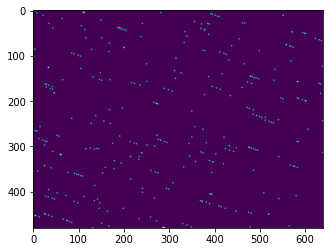

In [67]:
def detect_base(frame):
    Imaxima = morphology.h_maxima(frame, 0.03).astype('float')
    return Imaxima

Imaxima = detect_base(frames_f[0])

plt.imshow(morphology.dilation(Imaxima))
plt.show()

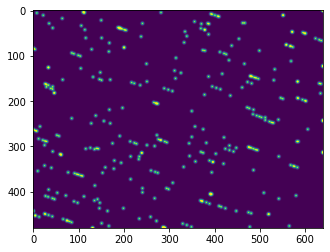

In [68]:
from heatmap import Heatmap

h1 = Heatmap(sigma=2).from_delta(detect_base(frames_f[0]))

plt.imshow(h1)
plt.show()

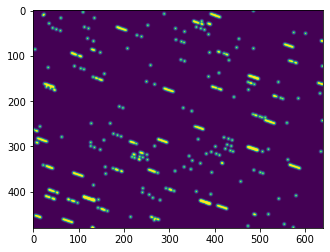

In [69]:
from skimage import restoration

def detect_with_rl(frame):
    Idelta = np.zeros((11, 11))
    Idelta[5, 5] = 1
    
    psf = filters.gaussian(Idelta, sigma=1) + np.random.exponential(1e-2, size=Idelta.shape)
    
    Ires = restoration.richardson_lucy(frame, psf)
    
    Imaxima = morphology.h_maxima(Ires, 0.15).astype('float')
    
    return Imaxima

h2 = Heatmap(sigma=2).from_delta(detect_rl(frames_f[0]))

plt.imshow(h2)
plt.show()

In [70]:
def detect_with_wavelet(frame):
    Ires = restoration.denoise_wavelet(frame, rescale_sigma=True)
    Imaxima = morphology.h_maxima(Ires, 0.03).astype('float')
    return Imaxima
    
h3 = Heatmap(sigma=3).from_delta(detect_with_wavelet(frames_f[0]))

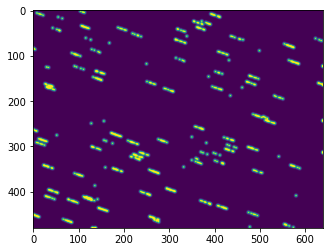

In [168]:
from skimage import feature

def detect_with_blob_log(frame):
    coords = feature.blob_log(frames_f[frameid], threshold=0.02, num_sigma=3, min_sigma=0.8, max_sigma=0.9)
    Iout = np.zeros((480, 640))
    for r, c, _ in coords:
        Iout[int(r), int(c)] = 1
        
    return Iout

h4 = Heatmap(sigma=2).from_delta(detect_with_blob_log(frames_f[0]))

plt.imshow(h4)
plt.show()

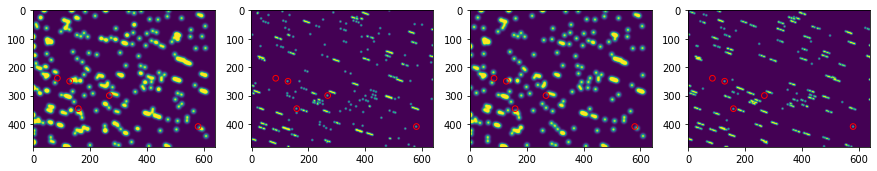

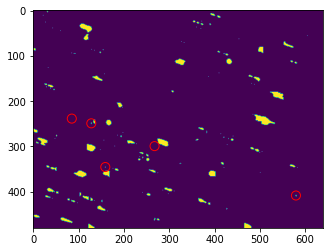

In [174]:
hs = [h1, h2, h3, h4]
h = np.mean(hs, axis=0)

frameid = 0

fig, axs = plt.subplots(1, len(hs), figsize=(15, 5))
axs = axs.ravel()

for i, hi in enumerate(hs):
    axs[i].imshow(hi)
    for x, y in targets[:, frameid]:
        draw_target(axs[i], y, x)
plt.show()

plt.imshow(h > 2./len(hs), vmin=0, vmax=1)
for x, y in targets[:, frameid]:
    draw_target(plt.gcf().gca(), y, x)
plt.show()

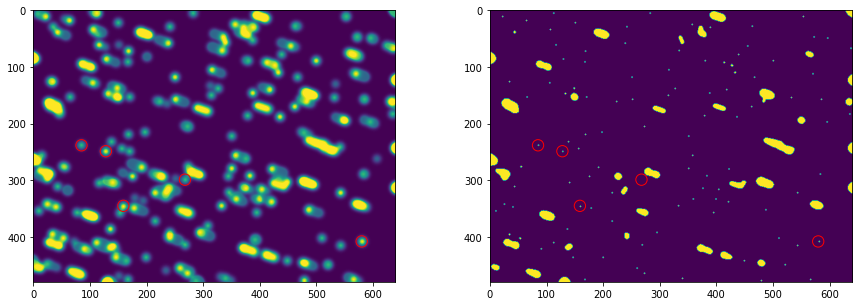

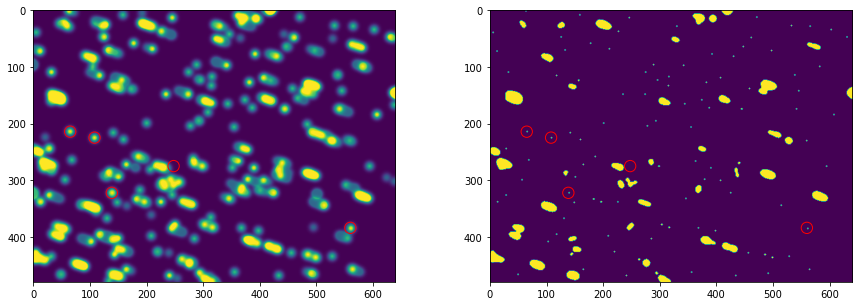

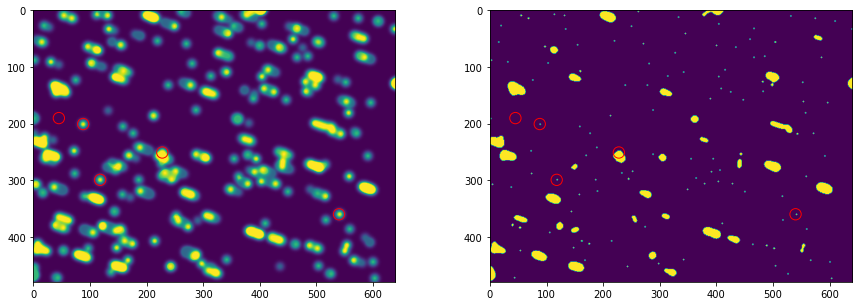

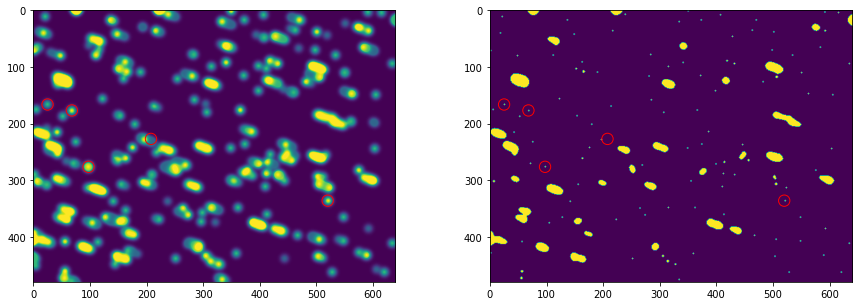

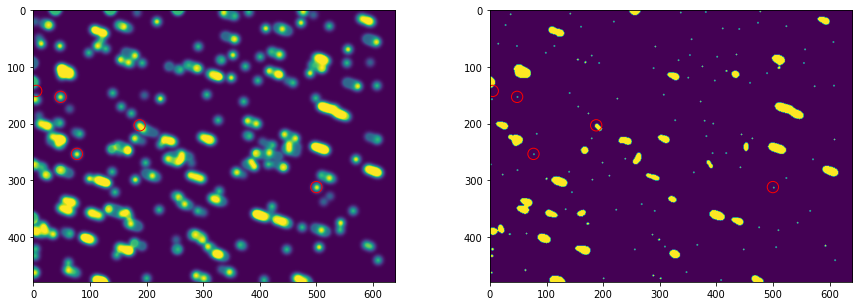

In [180]:
for frameid in range(0, 5):

    h1 = Heatmap(sigma=5).from_delta(detect_base(frames_f[frameid]))
    h3 = Heatmap(sigma=5).from_delta(detect_with_wavelet(frames_f[frameid]))
    h4 = Heatmap(sigma=5).from_delta(detect_with_blob_log(frames_f[frameid]))
    
    hs = [h1, h3, h4]
    
    h = np.mean(hs, axis=0)
    Imaxima = morphology.h_maxima(h, 1./len(hs))

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    axs[0].imshow(h, vmin=0, vmax=1)
    axs[1].imshow(morphology.dilation(Imaxima), vmin=0, vmax=1)
    
    for x, y in targets[:, frameid]:
        draw_target(axs[0], y, x)
        draw_target(axs[1], y, x)
    plt.show()

In [316]:
from skimage import measure

f_coords = []

for frameid in range(0, 5):

    h1 = Heatmap(sigma=5).from_delta(detect_base(frames_f[frameid]))
    h3 = Heatmap(sigma=5).from_delta(detect_with_wavelet(frames_f[frameid]))
    h4 = Heatmap(sigma=5).from_delta(detect_with_blob_log(frames_f[frameid]))
    
    hs = [h1, h3, h4]
    
    h = np.mean(hs, axis=0)
    Imaxima = morphology.h_maxima(h, 1./len(hs))

    Ilabels = morphology.label(Imaxima)
    regions = measure.regionprops(Ilabels)
    
    coords = [np.flip(region.centroid) for region in regions]
    coords = np.array(coords)
    
    print(len(coords))
    
    f_coords.append(coords)

143
143
151
141
138


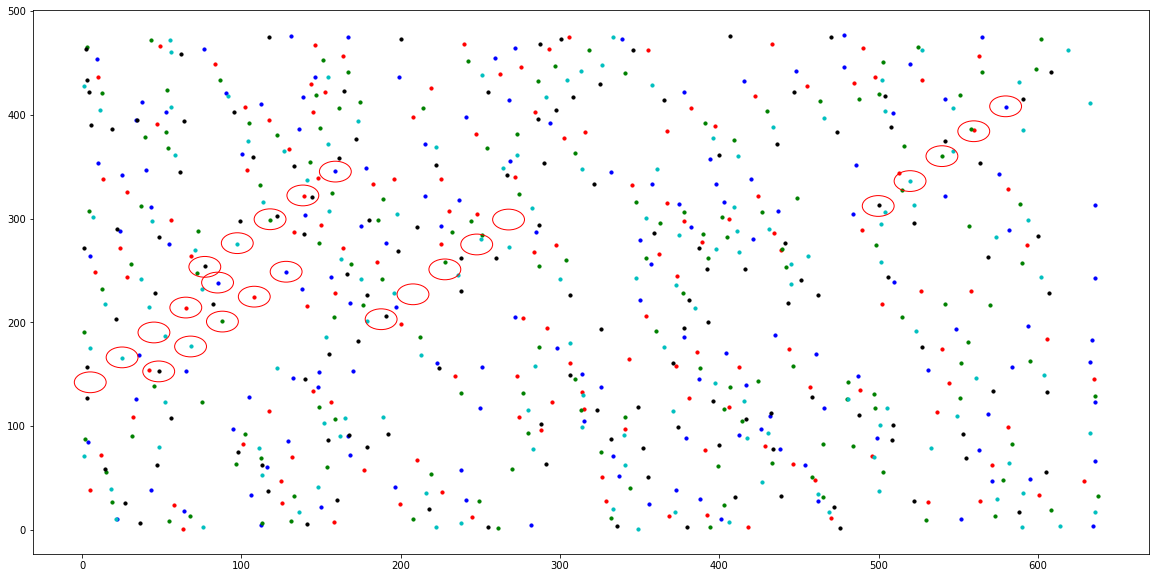

In [318]:
colors = ['b', 'r', 'g', 'c', 'k']

plt.figure(figsize=(20, 10))

for i, coords in enumerate(f_coords):
    plt.scatter(coords[:, 0], coords[:, 1], c=colors[i], s=10)
    for x, y in targets[:, i]:
        draw_target(plt.gcf().gca(), y, x)
plt.show()

In [350]:
def extract_region(arr, r0, c0, radius):
    """ Returns the values within a radius of the given x, y coordinates """
    return arr[(r0 - radius) : (r0 + radius + 1), (c0 - radius) : (c0 + radius + 1)]

frameid = 0
s = targets[:, frameid]

from sklearn import neighbors

nbrs = neighbors.NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(f_coords[0])

idxs = nbrs.kneighbors(s, return_distance=False)

mask = np.array([i in idxs for i in range(len(f_coords[0]))])

t_coords = f_coords[0][mask]
n_coords = f_coords[0][~mask]

print('t_coords', t_coords)

print(f_coords[0].shape)
print(n_coords.shape, t_coords.shape)

t_regions = [extract_region(frames_f[0], int(r0), int(c0), 5) for c0, r0 in t_coords]
n_regions = [extract_region(frames_f[0], int(r0), int(c0), 5) for c0, r0 in n_coords]

print('t_regions', len(t_regions))
print('n_regions', len(n_regions))

from skimage import transform

for i, region in enumerate(n_regions):
    if region.shape[0] > 0 and region.shape[1] > 0:
        n_regions[i] = transform.resize(region, (11, 11))
    else:
        n_regions[i] = np.zeros((11, 11))

for i, region in enumerate(t_regions):
    if region.shape[0] > 0 and region.shape[1] > 0:
        t_regions[i] = transform.resize(region, (11, 11))
    else:
        t_regions[i] = np.zeros((11, 11))
        
print('t_regions', len(t_regions))
print('n_regions', len(n_regions))

# n_regions = [transform.resize(region, (11, 11)) for region in n_regions if region.shape[0] > 0 and region.shape[1] > 0]

t_regions = np.array(t_regions)
n_regions = np.array(n_regions)

print( t_regions.shape )
print( n_regions.shape )

coords = np.concatenate([t_coords, t_coords, t_coords, t_coords, n_coords])

X = np.concatenate([t_regions, t_regions, t_regions, t_regions, n_regions]).reshape(-1, 121)
y = np.array([1]*4*len(t_regions) + [0]*len(n_regions))

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

print(X_train.shape)

print(y_test)


[[128.03430176 248.88623047]
 [ 84.98162842 238.44226074]
 [267.69189453 299.15264893]
 [579.78234863 408.21807861]
 [158.93579102 345.34063721]]
t_coords [[ 85.         238.        ]
 [128.         249.        ]
 [285.18726592 287.25093633]
 [159.         346.        ]
 [580.         408.        ]]
(143, 2)
(138, 2) (5, 2)
t_regions 5
n_regions 138
t_regions 5
n_regions 138
(5, 11, 11)
(138, 11, 11)
(105, 121)
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0]


158 158


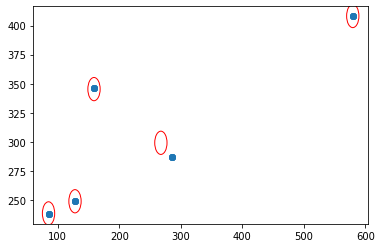

In [355]:
print(len(coords), len(y > 0))

frameid = 0

c = coords[y > 0]

plt.scatter(c[:, 0], c[:, 1])
for xt, yt in targets[:, frameid]:
    draw_target(plt.gcf().gca(), yt, xt)
plt.show()

In [360]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

clf = RandomForestClassifier(class_weight='balanced').fit(X_train, y_train)
print( metrics.f1_score(y_test, clf.predict(X_test)) )

print(clf.predict(X_test))
print(y_test)

1.0
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0]


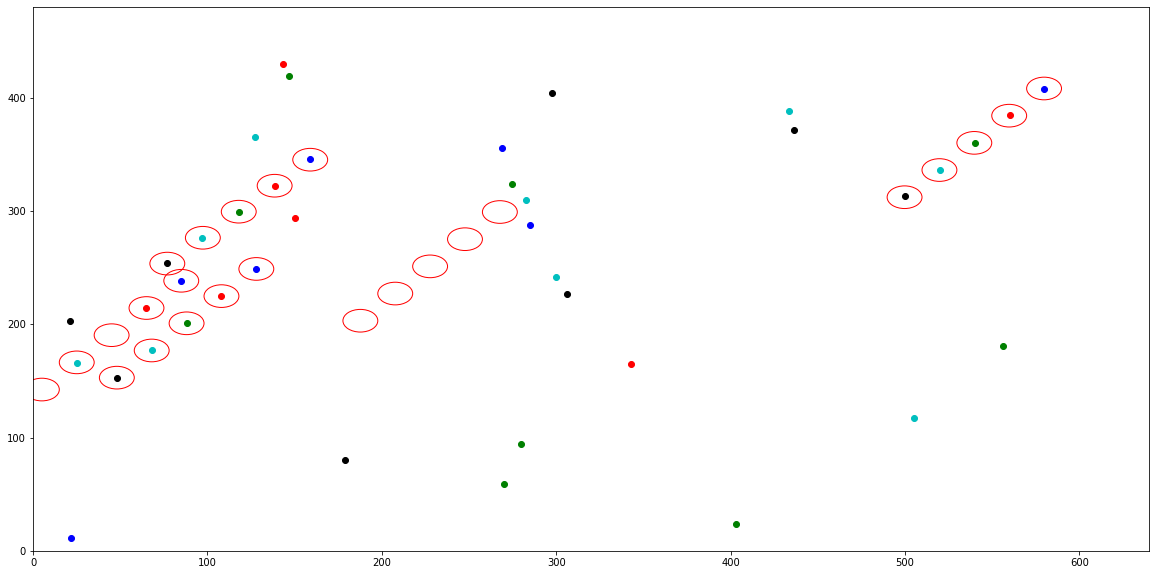

In [370]:
colors = ['b', 'r', 'g', 'c', 'k']

plt.figure(figsize=(20, 10))

for frameid, coords in enumerate(f_coords):
    
    regions = [extract_region(frames_f[frameid], int(r0), int(c0), 5) for c0, r0 in coords]
    
    for i, region in enumerate(regions):
        if region.shape[0] > 0 and region.shape[1] > 0:
            regions[i] = transform.resize(region, (11, 11))
        else:
            regions[i] = np.zeros((11, 11))
        
    x = np.array(regions).reshape(-1, 121)
    
    mask = clf.predict_proba(x)[:, 1] > 0.2
    
    plt.scatter(coords[mask][:, 0], coords[mask][:, 1], c=colors[frameid])
    
    for xt, yt in targets[:, frameid]:
        draw_target(plt.gcf().gca(), yt, xt)
        
plt.ylim(0, 480)
plt.xlim(0, 640)
        
plt.show()